In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import torch
from torch.utils.data import DataLoader

In [2]:
# Install Git
!apt-get install -y git

# Clone the repository
!git clone --depth 1 --branch main https://github.com/junzis/contrail-net.git

# Move to the data folder
%cd contrail-net/data


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 71 not upgraded.
Cloning into 'contrail-net'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 139 (delta 0), reused 134 (delta 0), pack-reused 0
Receiving objects: 100% (139/139), 9.64 MiB | 27.64 MiB/s, done.
/kaggle/working/contrail-net/data


In [3]:
!pip install segmentation_models_pytorch lightning

  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
  Obtaining dependency information for lightning from https://files.pythonhosted.org/packages/9e/8a/9642fdbdac8de47d68464ca3be32baca3f70a432aa374705d6b91da732eb/lightning-2.1.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.7 MB/s eta 0:00:00
  Obtaining dependency information f

In [15]:
# %%
import ssl
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import albumentations as albu
import segmentation_models_pytorch as smp
import lightning

import sys
sys.path.append('/kaggle/input/losses')
import loss

# %%
# avoid error for downloading pre-trained model
ssl._create_default_https_context = ssl._create_unverified_context

# %%
default_encoder = "resnet50"


# %%
# helper function for data visualization
def image_visualize(**images):
    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 5, 5))

    for i, (name, image) in enumerate(images.items()):
        image = preprocess_image(image)
        axes[i].imshow(image.squeeze())
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(" ".join(name.split("_")).title())

    fig.tight_layout()
    plt.show()

def preprocess_image(image):
    """
    Preprocess the image for visualization.
    """
    image = (image - image.min()) / (image.max() - image.min())
    if image.ndim == 3:
        if image.shape[0] == 3:
            image = image.transpose(1, 2, 0)
    return image


# %%
# classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.

    Args:
        image_paths (str): path to images folder
        mask_paths (str): path to segmentation masks folder, Default: None
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, perspective, gamma, etc.)
        preprocessing (albumentations.Compose): data preprocessing from pre-trained model
            (e.g. normalization, shape manipulation, etc.)
    """

    def __init__(self, image_paths, mask_paths=None, augmentation=None, preprocessing=None):
        self.ids = image_paths
        self.image_paths = image_paths

        self.has_mask = True if mask_paths is not None else False
        if self.has_mask:
            self.mask_paths = mask_paths

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def _read_image(self, i):
        # read image in color
        image = cv2.imread(self.image_paths[i], cv2.IMREAD_COLOR)
        return image

    def _read_mask(self, i):
        # read mask (png) and convert to grayscale
        mask = np.amax(cv2.imread(self.mask_paths[i], cv2.IMREAD_UNCHANGED), axis=2)
        mask = mask / mask.max()
        return mask

    def _apply_transformations(self, image, mask):
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __getitem__(self, i):
        image = self._read_image(i)

        if self.has_mask:
            mask = self._read_mask(i)
            image, mask = self._apply_transformations(image, mask)
            return image, mask

        else:
            image = self._apply_transformations(image, None)
            return image

    def __len__(self):
        return len(self.ids)



# %%

def get_augmentation(mode: str) -> albu.Compose:
    """
    Define augmentation for contrail images.

    Args:
        mode: One of "train", "val", or "test".

    Returns:
        albu.Compose: Augmentation pipeline.
    """

    transform = [
        albu.ShiftScaleRotate(
            scale_limit=0.2,
            rotate_limit=180,
            shift_limit=0.3,
            border_mode=0,
            p=1.0,
        ),
        albu.PadIfNeeded(
            min_height=320, min_width=320, always_apply=True, border_mode=0
        ),
        albu.Resize(320, 320),
    ]

    if mode == "train":
        transform += [
            albu.OneOf(
                [
                    albu.RandomBrightnessContrast(
                        brightness_limit=0.2, contrast_limit=0.3, p=1.0
                    ),
                    albu.RandomGamma(gamma_limit=(20, 100), p=1.0),
                ],
                p=0.5,
            )
        ]

    return albu.Compose(transform)


def get_preprocessing() -> albu.Compose:
    """
    Construct preprocessing transform.

    Returns:
        albu.Compose: Preprocessing pipeline.
    """

    def train_to_tensor(image, **kwargs):
        return image.transpose(2, 0, 1).astype("float32")

    def mask_to_tensor(mask, **kwargs):
        return np.expand_dims(mask, 0).astype("float32")

    return albu.Compose(
        [
            albu.Lambda(image=smp.encoders.get_preprocessing_fn(default_encoder)),
            albu.Lambda(image=train_to_tensor, mask=mask_to_tensor),
        ]
    )
# %%


# pytorch model based on lighting
class ContrailModel(lightning.LightningModule):
    def __init__(self, arch, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=default_encoder,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        self.train_per_image_iou = []
        self.train_dataset_iou = []
        self.valid_per_image_iou = []
        self.valid_dataset_iou = []
        # preprocessing parameters for image
        params = smp.encoders.get_preprocessing_params(default_encoder)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        loss_name = kwargs.get("loss", "dice").lower()
        assert loss_name in ["dice", "focal", "sr"]

        if loss_name == "dice":
            self.loss_fn = loss.DiceLoss(from_logits=True)
        if loss_name == "focal":
            self.loss_fn = loss.FocalLoss(normalized=True)
        if loss_name == "sr":
            self.loss_fn = loss.SRLoss(from_logits=True)

        self.outputs = {"train": [], "valid": []}

    def forward(self, image):
        # normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # for grayscale images, expand channels dim to be [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32);
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Compute metrics for some threshold
        # first convert mask values to probabilities, then apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # Compute true positive, false positive, false negative and true negative
        # of 'pixels' for each image and class. Aggregate them at epoch end.
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )

        stats = {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

        self.outputs[stage].append(stats)

        return stats

    def shared_epoch_end(self, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in self.outputs[stage]])
        fp = torch.cat([x["fp"] for x in self.outputs[stage]])
        fn = torch.cat([x["fn"] for x in self.outputs[stage]])
        tn = torch.cat([x["tn"] for x in self.outputs[stage]])

        # First calculate IoU score for each image, then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # aggregate intersection and union over whole dataset and compute IoU score.
        # For dataset with "empty" images (images without target class), a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        if stage == "train":
            self.train_per_image_iou.append(per_image_iou)
            self.train_dataset_iou.append(dataset_iou)
        elif stage == "valid":
            self.valid_per_image_iou.append(per_image_iou)
            self.valid_dataset_iou.append(dataset_iou)
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        self.shared_epoch_end("train")
        self.outputs["train"].clear()

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        self.shared_epoch_end("valid")
        self.outputs["valid"].clear()

    def configure_optimizers(self):
        # return torch.optim.Adam(self.parameters(), lr=0.0001)
        return torch.optim.Adam(self.parameters())

# %%


In [5]:
#import contrail

model = ContrailModel("UNet", in_channels=3, out_classes=1)
model.load_state_dict(torch.load("/kaggle/input/models/model/contrail.torch.dice.bin"))

model2 = ContrailModel("UNet", in_channels=3, out_classes=1)
model2.load_state_dict(
    torch.load("/kaggle/input/models/model/contrail.torch.focal.bin")
)

model3 = ContrailModel("UNet", in_channels=3, out_classes=1)
model3.load_state_dict(torch.load("/kaggle/input/models/model/contrail.torch.sr.bin"))


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 261MB/s] 


<All keys matched successfully>

In [6]:
outpath = "/content/drive/MyDrive/data_proj/"

In [7]:
test_image_paths = sorted(glob.glob("/kaggle/working/contrail-net/data/test*/image/*.png"))
test_mask_paths = sorted(glob.glob("/kaggle/working/contrail-net/data/test*/mask/*.png"))
print(test_image_paths)

['/kaggle/working/contrail-net/data/test_florida/image/florida_2020_03_17_0921.png', '/kaggle/working/contrail-net/data/test_florida/image/florida_2020_03_17_0926.png', '/kaggle/working/contrail-net/data/test_florida/image/florida_2020_03_17_0951.png', '/kaggle/working/contrail-net/data/test_florida/image/florida_2020_03_17_1231.png', '/kaggle/working/contrail-net/data/test_florida/image/florida_2020_05_07_1351.png', '/kaggle/working/contrail-net/data/test_florida/image/florida_2020_05_07_1356.png', '/kaggle/working/contrail-net/data/test_florida/image/florida_2020_05_07_1601.png', '/kaggle/working/contrail-net/data/test_san-francisco/image/san-francisco_2020_05_06_0246.png', '/kaggle/working/contrail-net/data/test_san-francisco/image/san-francisco_2020_05_06_0251.png', '/kaggle/working/contrail-net/data/test_san-francisco/image/san-francisco_2020_05_06_0311.png']


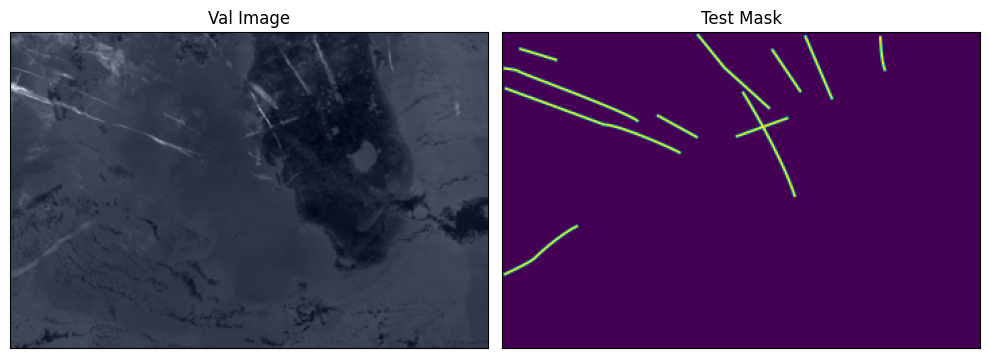

In [8]:
import glob
test_dataset = Dataset(
    test_image_paths,
    test_mask_paths,
    preprocessing=get_preprocessing(),
)
image, mask = test_dataset[0]
image_visualize(val_image=image, test_mask=mask)

In [9]:
test_dataset = Dataset(
    test_image_paths,
    test_mask_paths,
    augmentation=get_augmentation("test"),
    preprocessing=get_preprocessing(),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=10,
    shuffle=False,
)

test_batch = next(iter(test_dataloader))
print(len(test_batch))

2


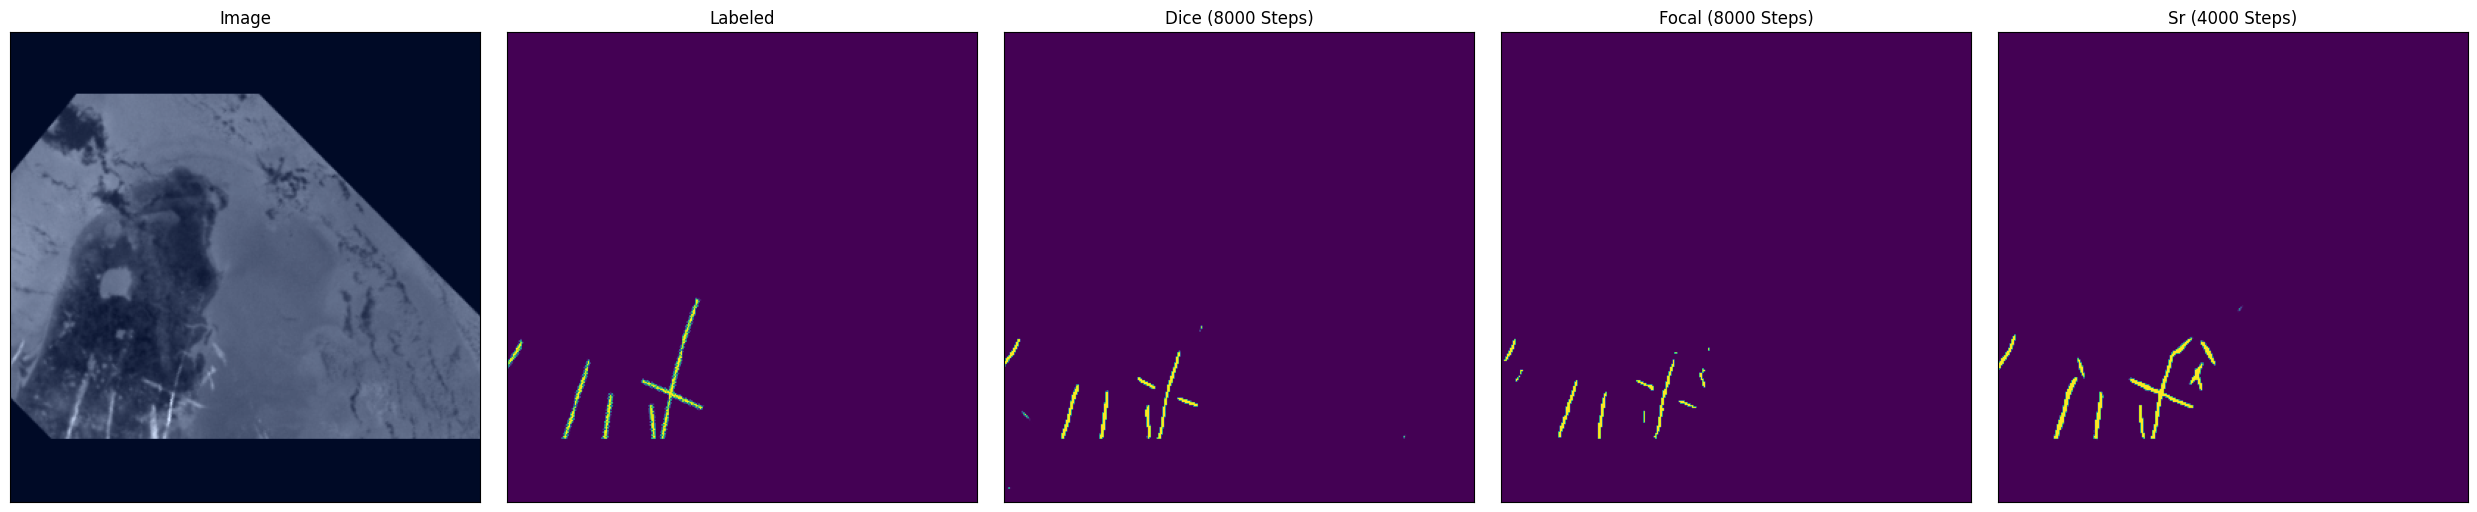

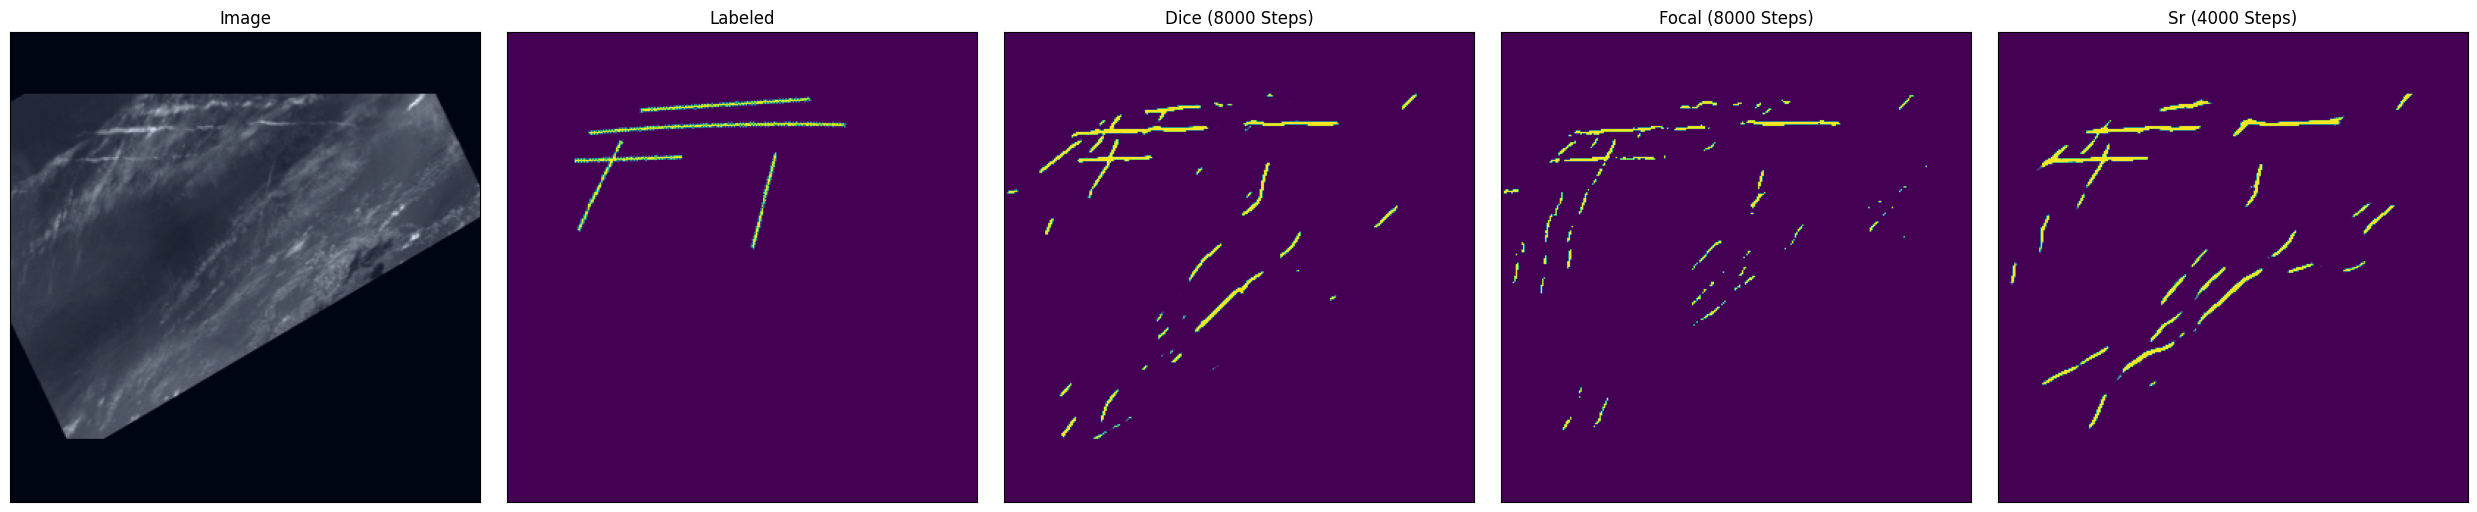

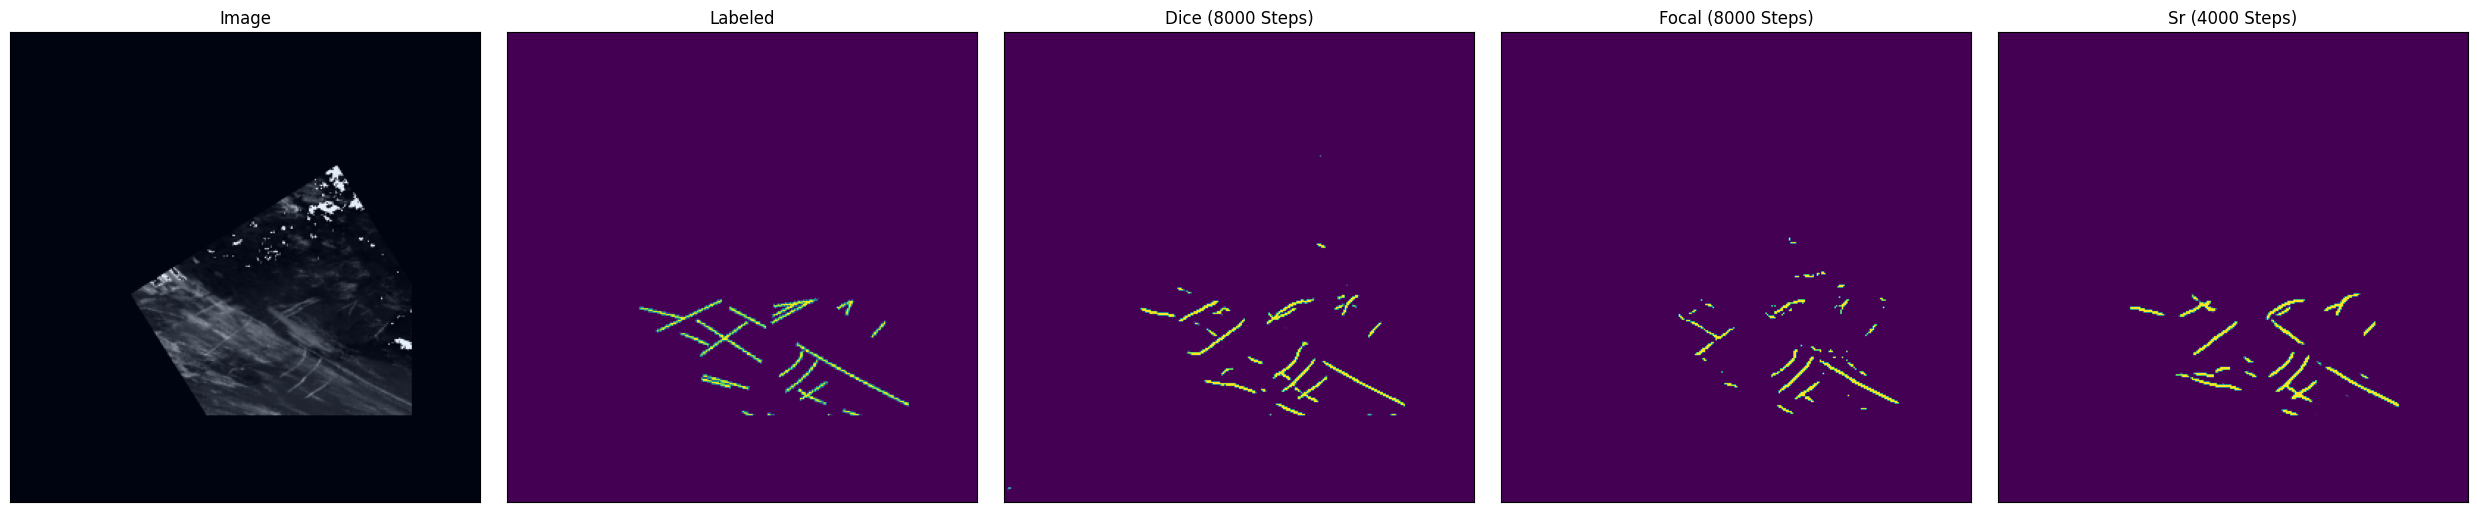

In [10]:

with torch.no_grad():
    model.eval()
    pred_masks_1 = model(test_batch[0]).sigmoid()


with torch.no_grad():
    model2.eval()
    pred_masks_2 = model2(test_batch[0]).sigmoid()
    pred_masks_2 = np.where(pred_masks_2 > 0.5, 1, 0)

with torch.no_grad():
    model3.eval()
    pred_masks_3 = model3(test_batch[0]).sigmoid()


results = []

for i in [0, 5, 9]:

    d = {
        "Image": np.array(test_batch[0][i]),
        "Labeled": np.array(test_batch[1][i]),
        "Dice (8000 steps)": np.array(pred_masks_1[i]),
        "Focal (8000 steps)": np.array(pred_masks_2[i]),
        "SR (4000 steps)": np.array(pred_masks_3[i]),
    }

    image_visualize(**d)
    results.append(d)


# pickle.dump(
#     results,
#     open(f"{outpath}/dice_vs_focal_vs_sr.pkl", "wb"),
# )


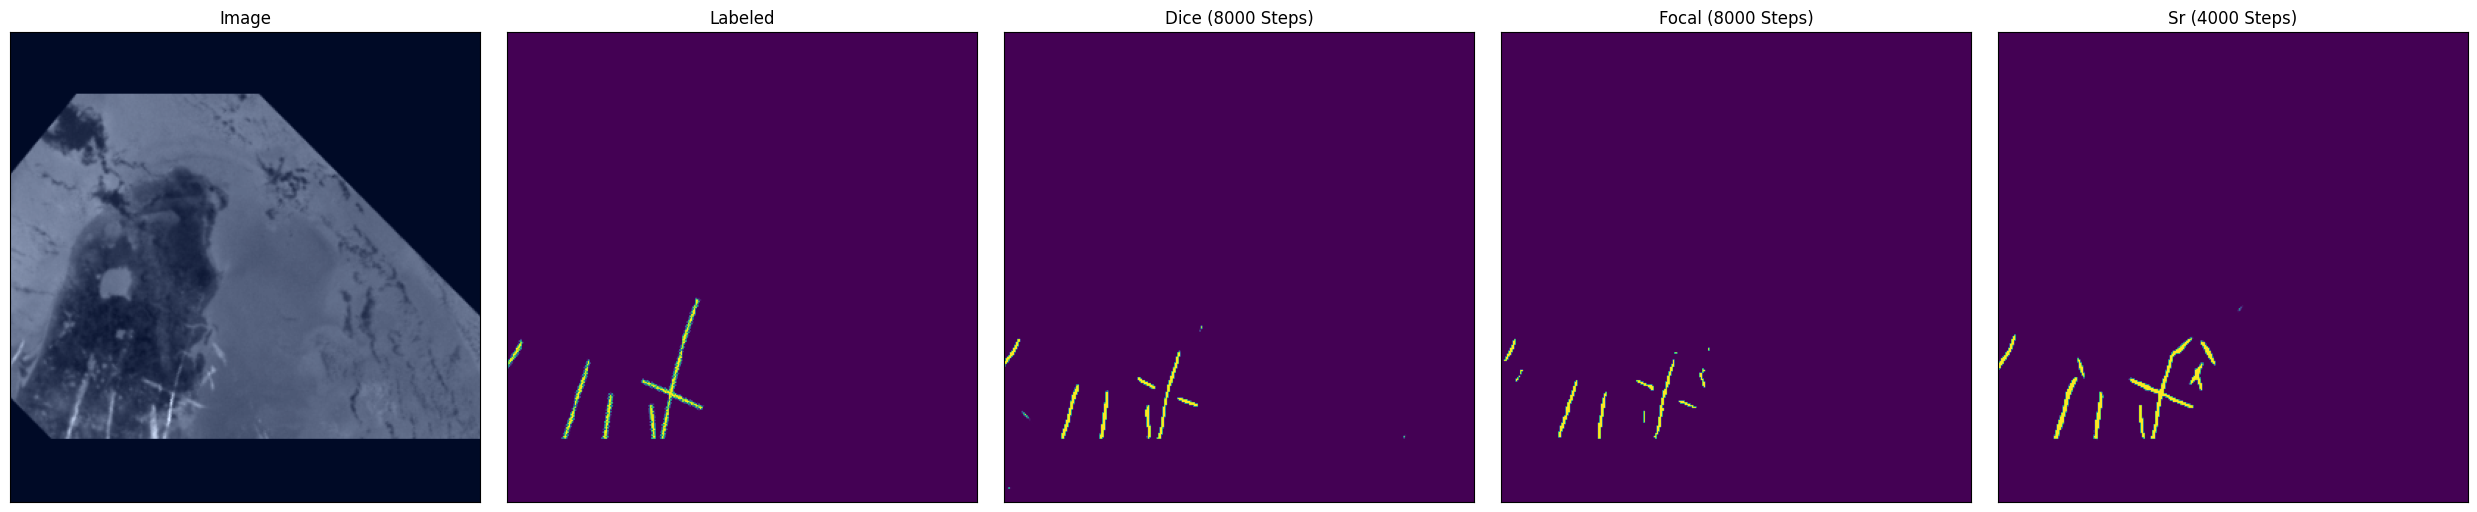

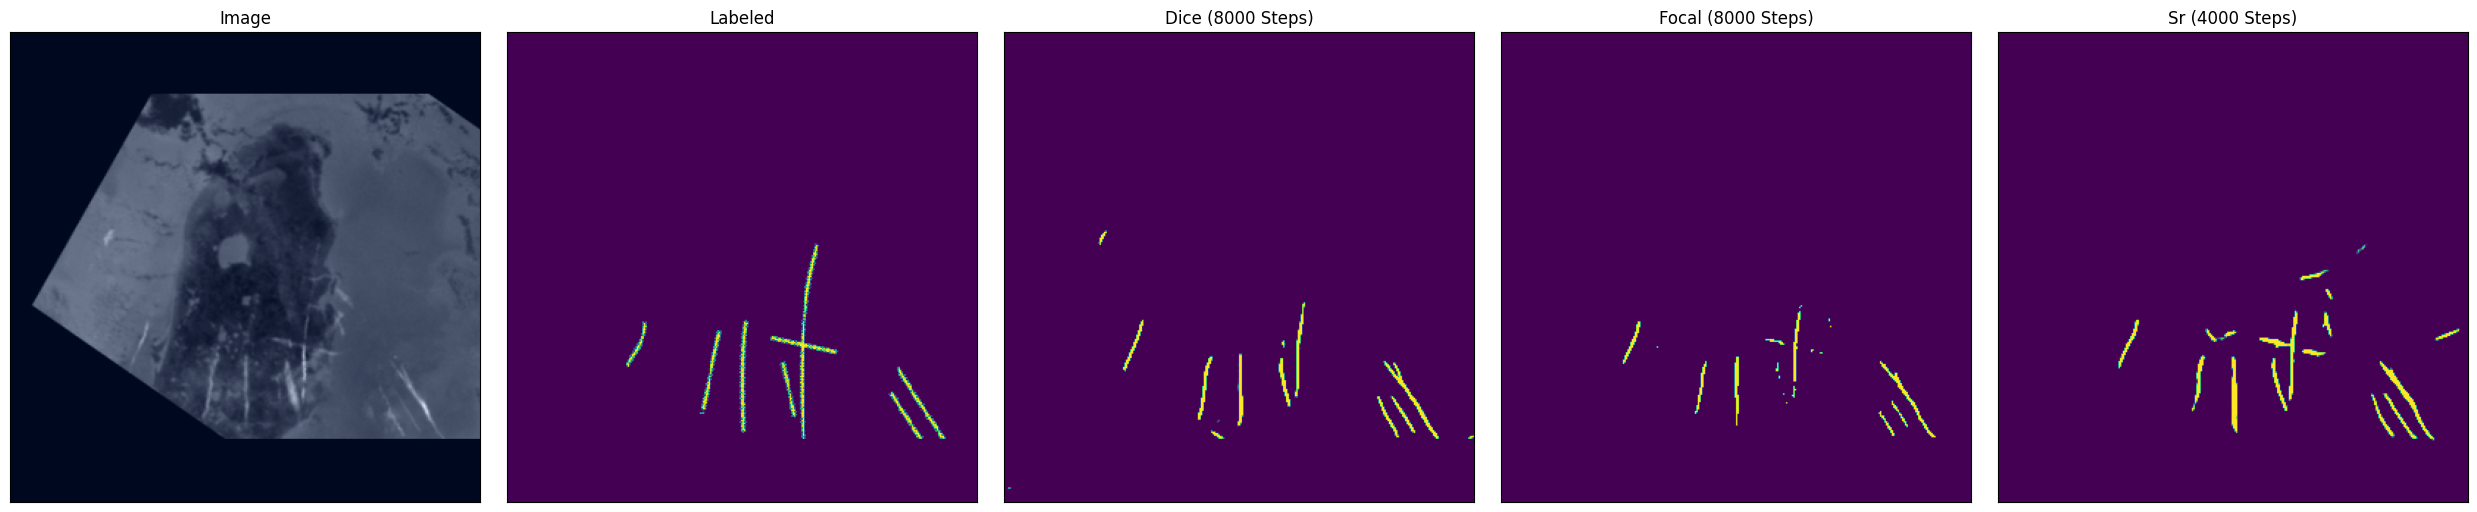

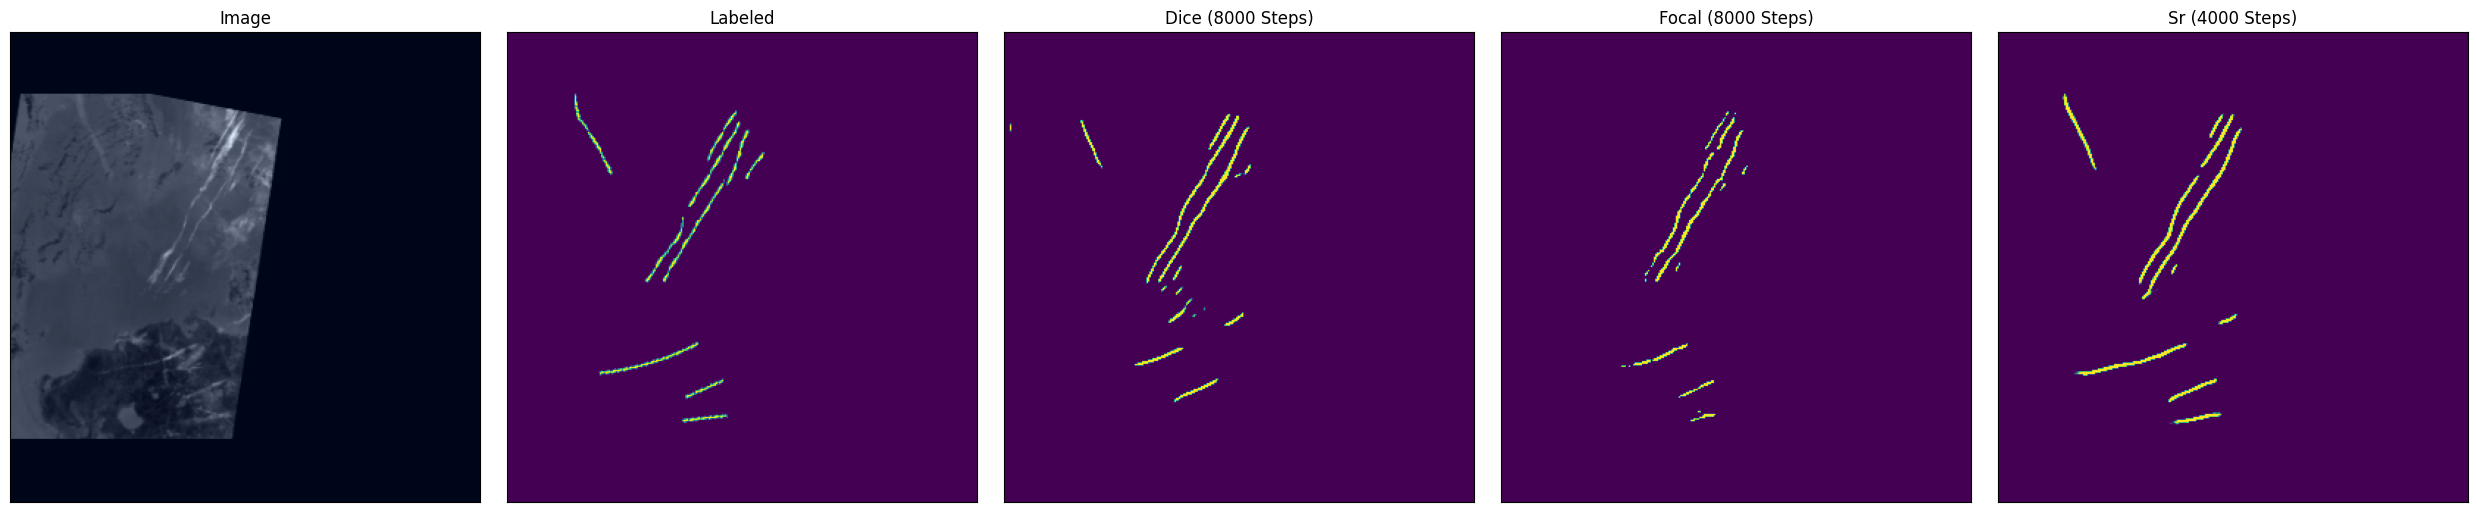

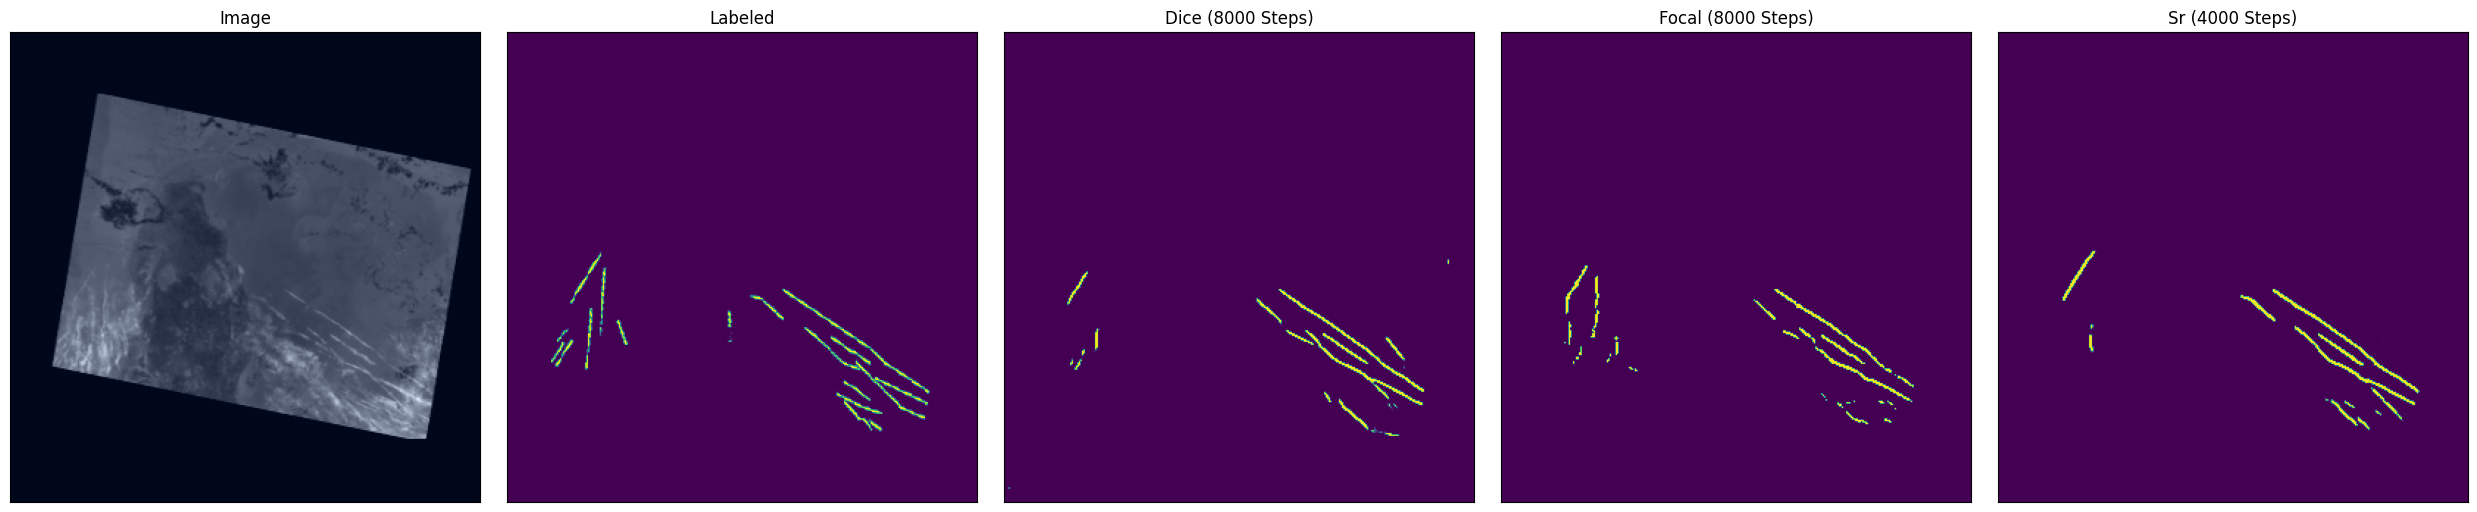

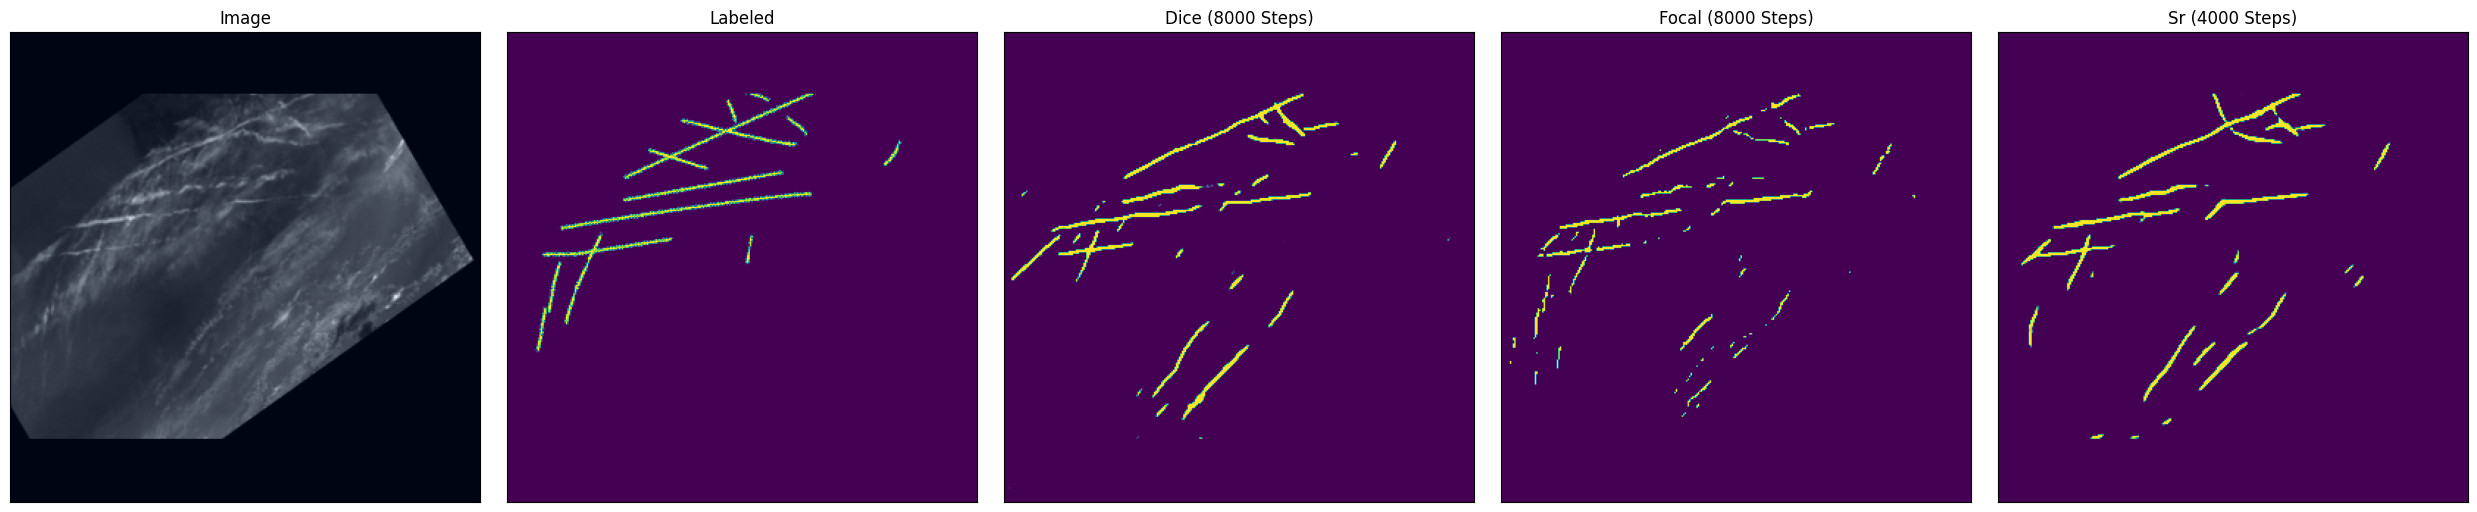

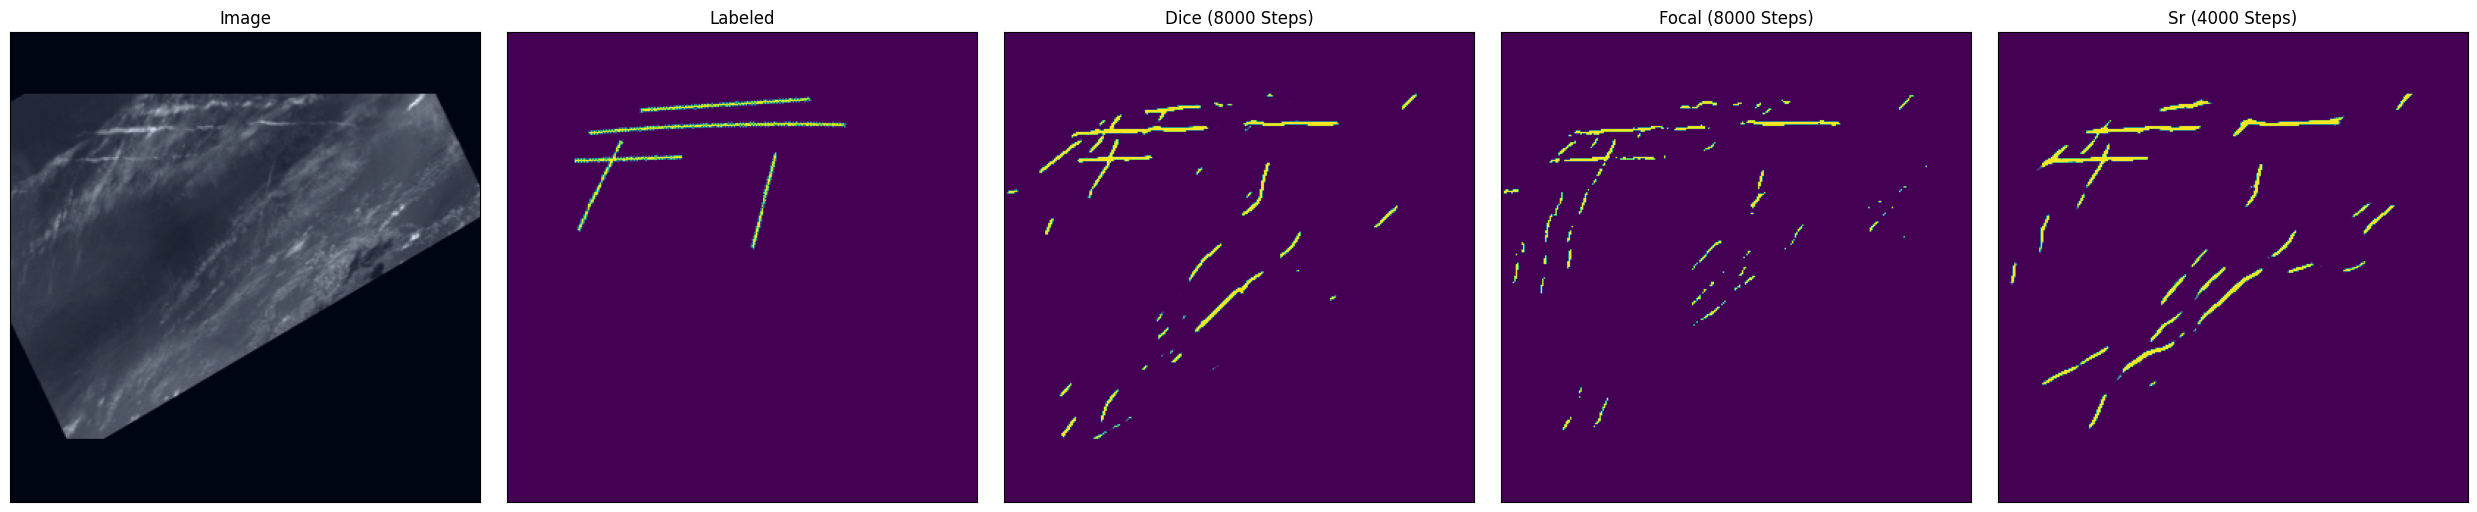

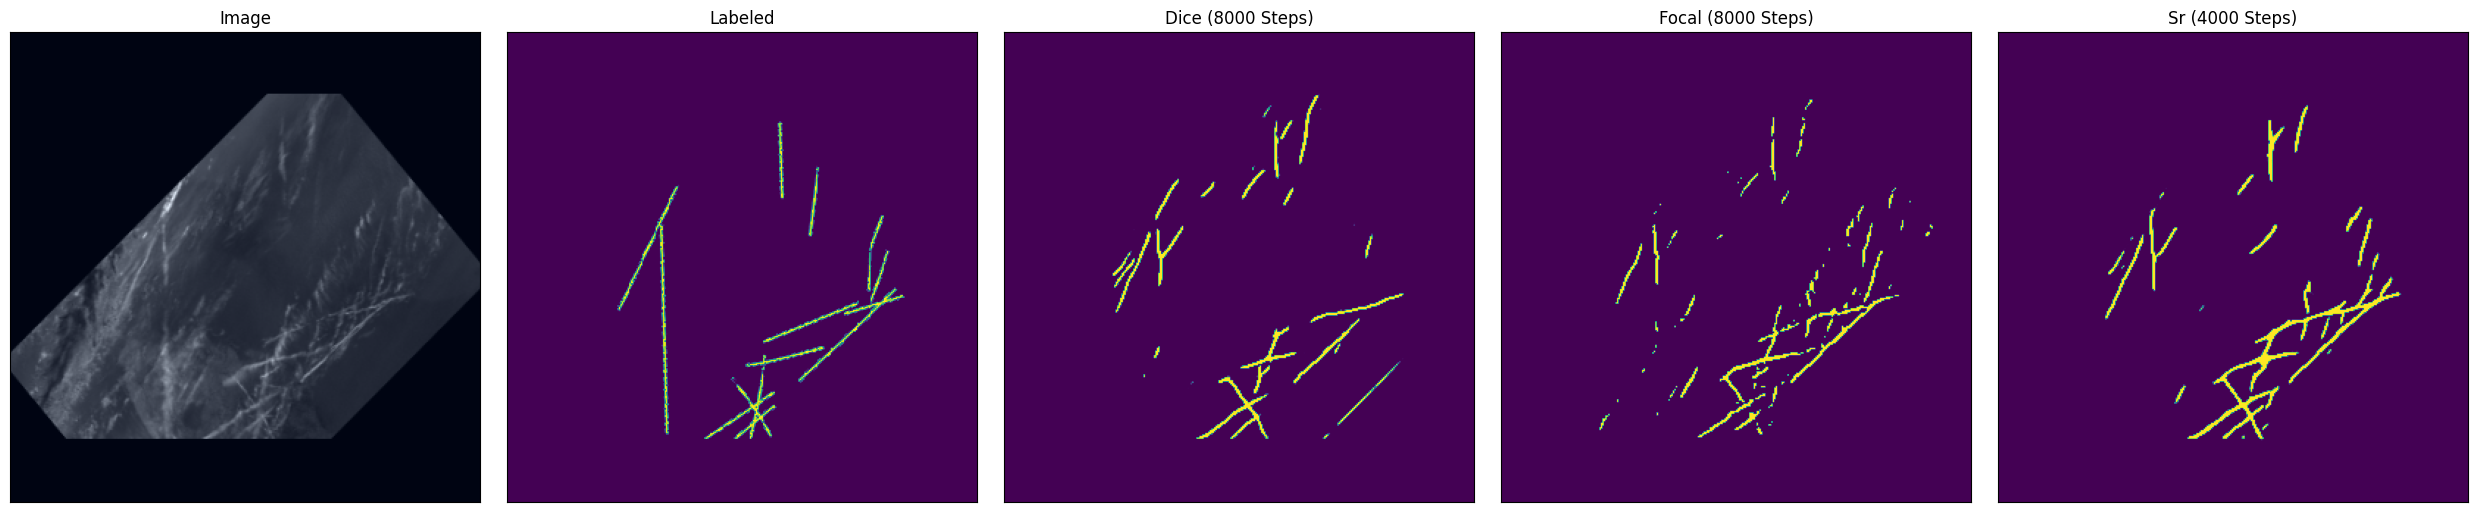

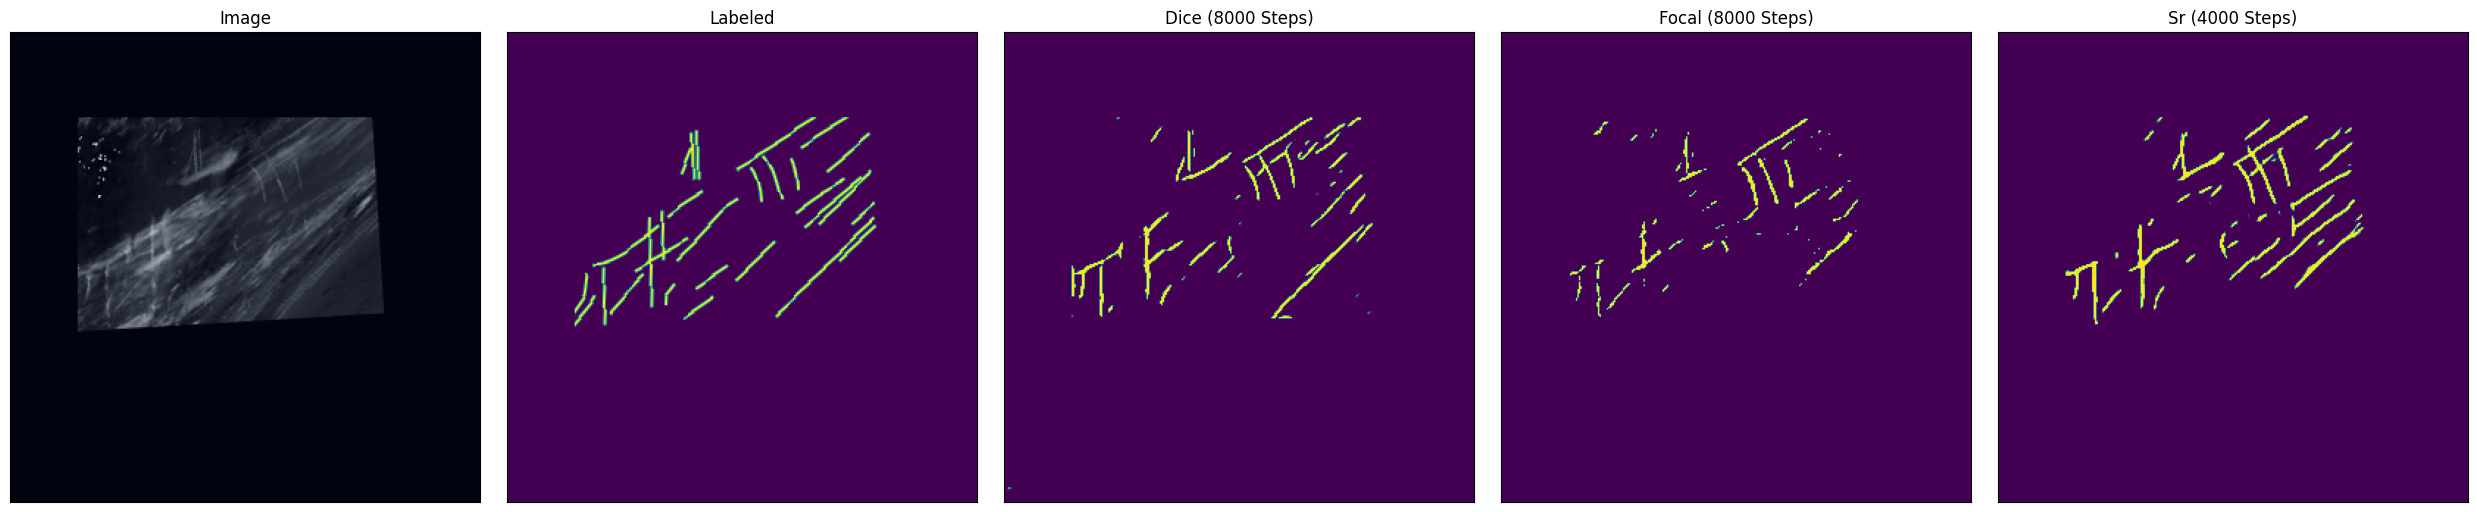

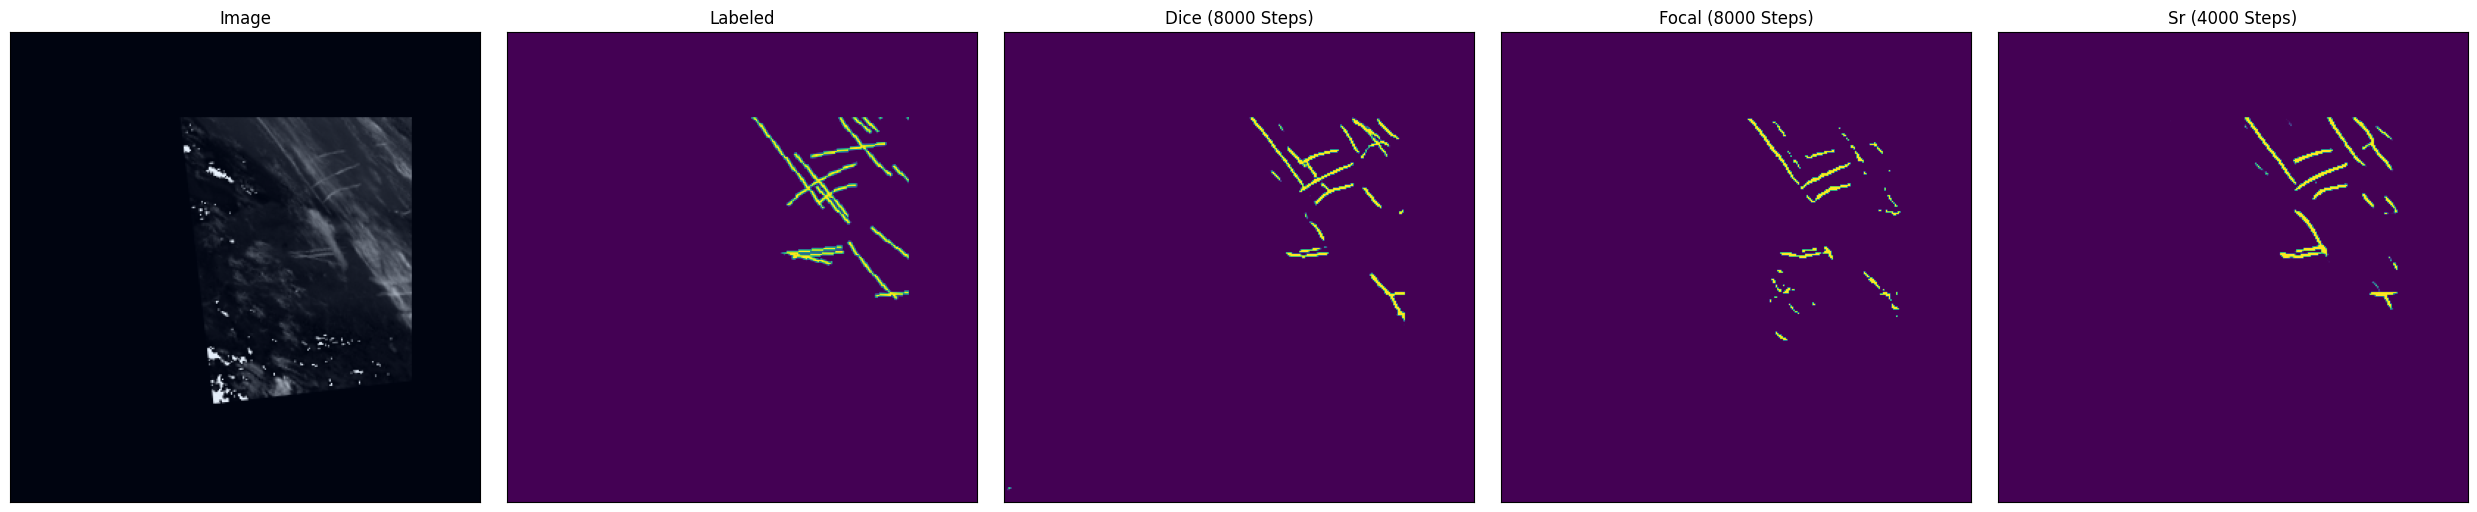

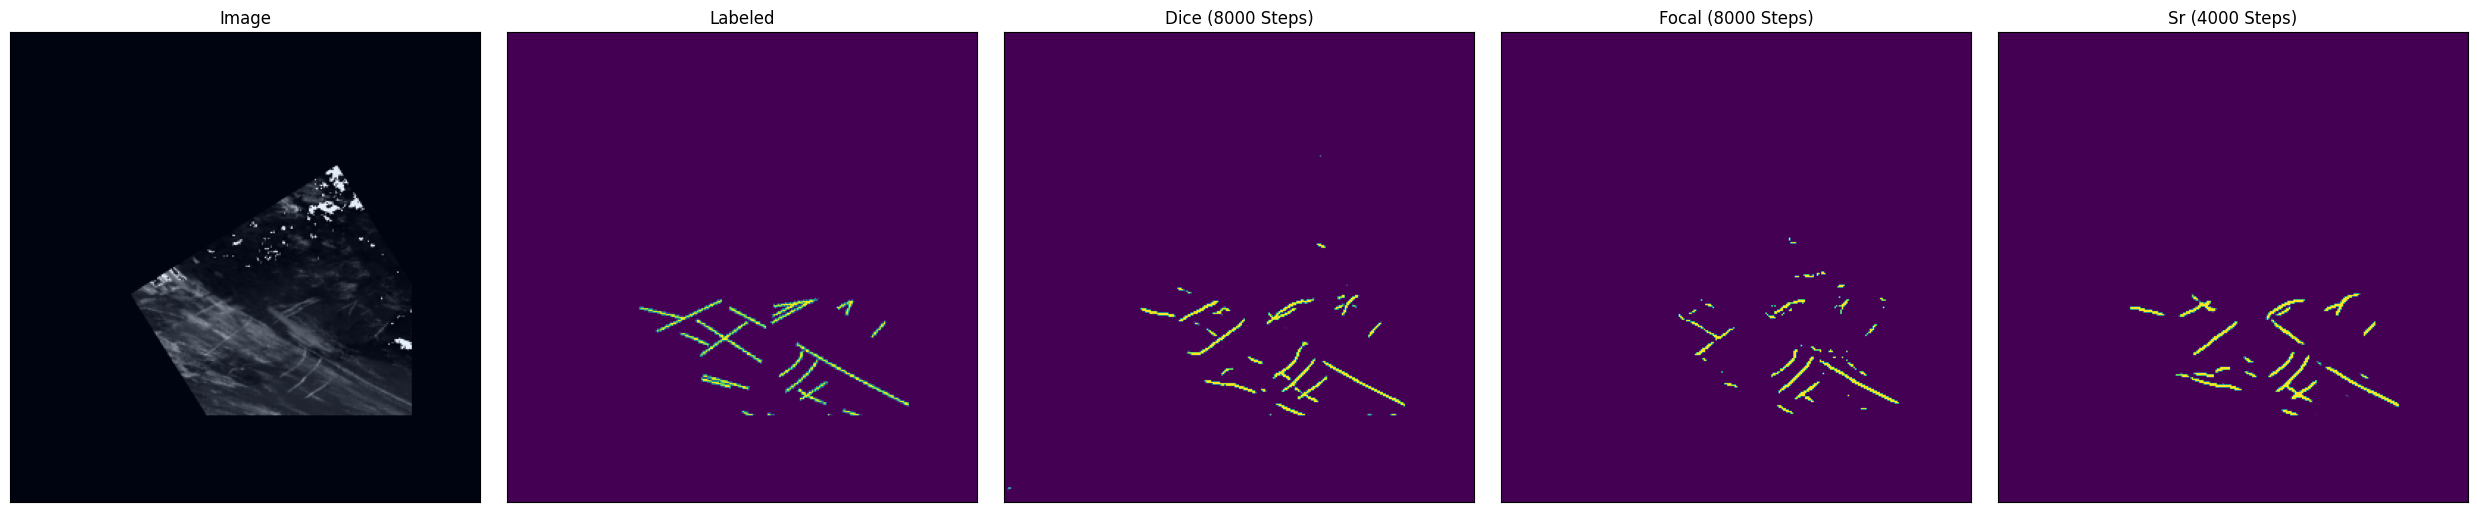

In [11]:
# show results for all image in the test set

for i in range(len(test_batch[0])):
    image = test_batch[0][i]
    labeled = test_batch[1][i]
    pred1 = pred_masks_1[i]
    pred2 = pred_masks_2[i]
    pred3 = pred_masks_3[i]

    d = {
        "Image": np.array(image),
        "Labeled": np.array(labeled),
        "Dice (8000 steps)": np.array(pred1),
        "Focal (8000 steps)": np.array(pred2),
        "SR (4000 steps)": np.array(pred3),
    }

    image_visualize(**d)


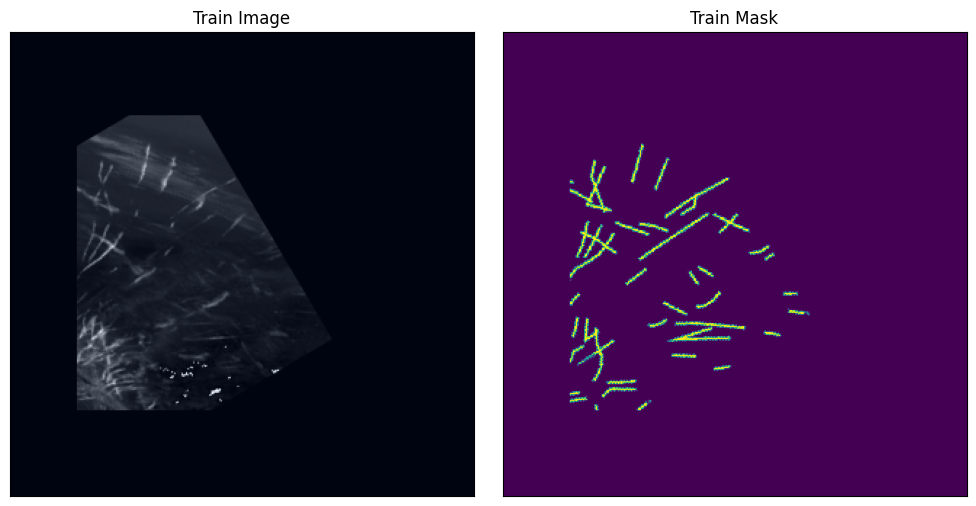

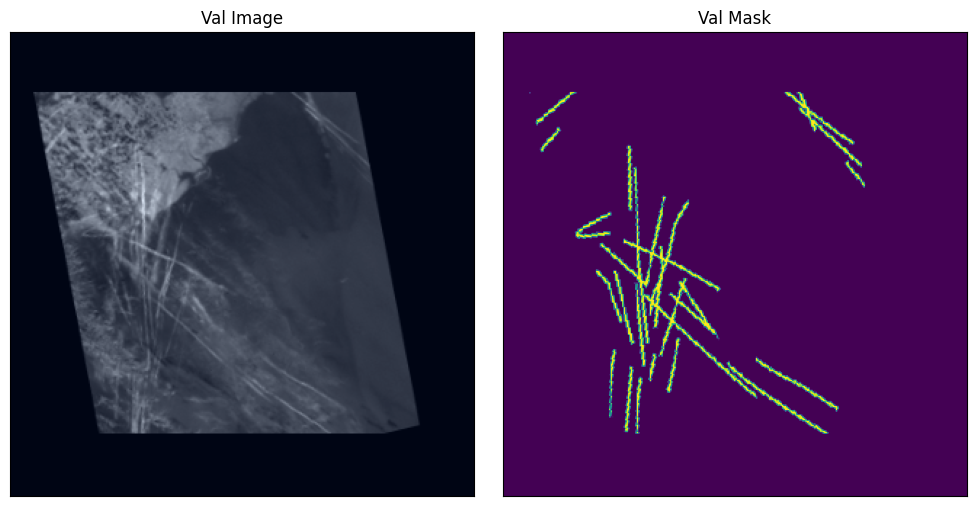

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 32.5 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.084   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=50` reached.


In [17]:
# %%
import glob
import warnings
import torch
import lightning
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from lightning.pytorch.callbacks.early_stopping import EarlyStopping



warnings.filterwarnings("ignore")

# %%
image_paths = sorted(glob.glob(f"/kaggle/working/contrail-net/data/train_*/image/*.png"))
mask_paths = sorted(glob.glob(f"/kaggle/working/contrail-net/data/train_*/mask/*.png"))

x_train, x_val, y_train, y_val = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)

# Dataset for train images
train_dataset = Dataset(
    x_train,
    y_train,
    augmentation=get_augmentation("train"),
    preprocessing=get_preprocessing(),
)

image, mask = train_dataset[0]
image_visualize(train_image=image, train_mask=mask)

# Dataset for validation images
val_dataset = Dataset(
    x_val,
    y_val,
    augmentation=get_augmentation("val"),
    preprocessing=get_preprocessing(),
)

image, mask = val_dataset[0]
image_visualize(val_image=image, val_mask=mask)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=16,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=16,
)

# %%

#loss = "sr"

# Training detection model
model = ContrailModel(arch="UNet", in_channels=3, out_classes=1)

trainer = lightning.Trainer(max_steps=50, log_every_n_steps=10)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# %%
torch.save(
    model.state_dict(), "/kaggle/working/contrail-net/data/contrail.torch.states.v[xx].[loss].[xxx].bin"
)


# we ran the above training for 5000 epoch with early stopping and saved the model. The prediction on the saved model is shown at the top. We forgot to save the IOU values, so running sample 50 epochs and plotting the IOU values.

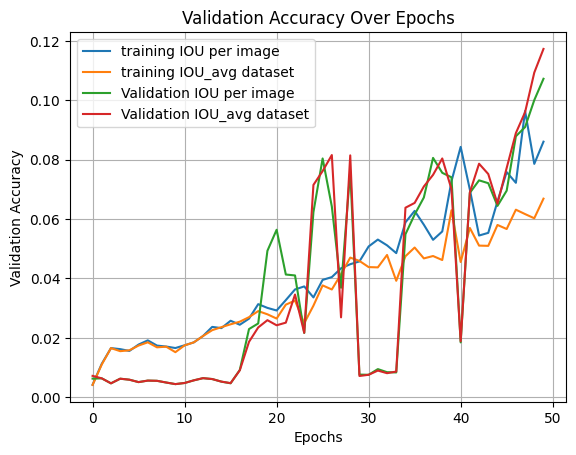

In [33]:

train_per_image_iou_values = model.train_per_image_iou
valid_per_image_iou_values = model.valid_per_image_iou
train_data_iou = model.train_dataset_iou
valid_data_iou = model.valid_dataset_iou
tr_iou_img = np.zeros((len(train_per_image_iou_values),))
val_iou_img = np.zeros((len(train_per_image_iou_values),))
tr_iou_data = np.zeros((len(train_per_image_iou_values),))
val_iou_data = np.zeros((len(train_per_image_iou_values),))
for i in range(len(train_per_image_iou_values)):
    tr_iou_img[i] = train_per_image_iou_values[i].detach().cpu().numpy()
    tr_iou_data[i] = train_data_iou[i].detach().cpu().numpy()
    val_iou_img[i] = valid_per_image_iou_values[i].detach().cpu().numpy()
    val_iou_data[i] = valid_data_iou[i].detach().cpu().numpy()
epochs = [i for i in range(50)]

plt.plot(epochs, tr_iou_img, linestyle='-', label='training IOU per image')
plt.plot(epochs, tr_iou_data, linestyle='-', label='training IOU_avg dataset')
plt.plot(epochs, val_iou_img, linestyle='-', label='Validation IOU per image')
plt.plot(epochs, val_iou_data,linestyle='-', label='Validation IOU_avg dataset')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Based on the prediction results and the accuracies, we understand that model that is trained with SR loss or DICE loss performed better than the model that is trained on Focal loss. Also, at some images, SR loss model performed way better than the dice loss model.